In [3]:
import numpy as np
import pandas as pd
import cv2
import pytesseract
from glob import glob
import spacy
import re
import string
import os
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings 
warnings.filterwarnings('ignore') 
#nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

In [4]:
model_ner = spacy.load('./model-best/')

## Parsing / Extract Skill

In [5]:
def merge_tokens(df):
    merged_tokens = []
    current_token = ''
    current_label = ''
    
    for i, row in df.iterrows():
        # hapus kata duplikat yang plural (database, databases)
        token = lemmatizer.lemmatize(row['tokens'].lower())
        label = row['label']
        
        if label.startswith('B-'):
            # merge token B dengan I (B-HSkill, I-HSkill)
            if current_token:
                merged_tokens.append((current_token, current_label))
            current_token = token
            current_label = label
        elif label.startswith('I-') and current_label[2:] == label[2:]:
            current_token += ' ' + token
        else:
            # jika token tidak valid, maka skip
            current_token = ''
            current_label = ''
    
    if current_token:
        merged_tokens.append((current_token, current_label))

    merged_tokens = list(set(merged_tokens))
    
    return merged_tokens

In [6]:
def parsing_ner(text):
    doc = model_ner(text)
    
    doc_json = doc.to_json()
    doc_text = doc_json['text']
    
    df_tokens = pd.DataFrame(doc_json['tokens'])
    df_tokens['tokens'] = df_tokens[['start', 'end']].apply(
        lambda x: doc_text[x[0]: x[1]], axis=1
    )
    
    right_table = pd.DataFrame(doc_json['ents'])[['start', 'label']]
    df_tokens = pd.merge(df_tokens, right_table, how='left', on='start')
    
    df_tokens = df_tokens.query('label == label')
    merged = merge_tokens(df_tokens)
    print(df_tokens)
    merged_df = pd.DataFrame(merged, columns=['tokens', 'label'])
    
    return merged_df.groupby('label').size().to_dict()

## Import data and Data preparation

In [7]:
resumes = pd.read_csv('./Dataset/extracted_resume_merged.csv')
#resumes = resumes.query('Category == "INFORMATION-TECHNOLOGY"')
resumes = resumes[['cleaned_text', 'Degree', 'total_exp', 'total_work']]
resumes = resumes.query("total_exp > 0 and total_exp <= 35")
resumes.head()

,cleaned_text,Degree,total_exp,total_work
0,information technology summary dedicated infor...,Master,25.33,3.0
2,information technology supervisor summary seek...,Undergraduate,9.67,4.0
3,information technology instructor summary seve...,Doctor,22.42,4.0
4,information technology manager/analyst profess...,Bachelor,24.92,3.0
5,christopher townes summary knowledgeable infor...,Undergraduate,7.42,3.0


In [10]:
results = resumes['cleaned_text'].apply(parsing_ner)
results_df = pd.DataFrame(results.tolist(), index=resumes.index)
resumes = resumes.join(results_df)
resumes = resumes.fillna(0)

for column in results_df.columns:
   resumes[column] = resumes[column].astype(int)

print(resumes.head())

      id  start   end   dep  head       tokens     label
1      1     12    22  ROOT     1   technology  I-HSkill
11    11     98   108  ROOT    11   mitigating    I-Tech
17    17    137   146  ROOT    17    solutions  I-HSkill
33    33    271   281  ROOT    33   enterprise  B-HSkill
39    39    321   331  ROOT    39   enterprise  B-HSkill
..   ...    ...   ...   ...   ...          ...       ...
508  508   3975  3982  ROOT   508      desktop  I-HSkill
510  510   3994  4002  ROOT   510     software  I-HSkill
512  512   4004  4013  ROOT   512    photoshop    B-Tech
514  514   4015  4026  ROOT   514  illustrator    B-Tech
516  516   4028  4032  ROOT   516         html    B-Tech

[91 rows x 7 columns]
      id  start   end   dep  head       tokens     label
1      1     12    22  ROOT     1   technology  I-HSkill
7      7     71    81  ROOT     7   technology  I-HSkill
13    13    114   124  ROOT    13   technology  I-HSkill
27    27    206   209  ROOT    27          set  B-HSkill
46    46

In [11]:
# Convert Degree ke Categorical data
resumes['deg'] = resumes['Degree'].astype('category').cat.codes

In [12]:
resumes.tail()

,cleaned_text,Degree,total_exp,total_work,B-HSkill,B-SSkill,B-Tech,deg
399,"jessica claire montgomery street , san francis...",Master,19.33,4.0,32,2,13,2
400,jc j js j js j js j js j js j js jessica clair...,Master,10.33,3.0,24,0,2,2
401,jc j js j js j js j js j js j js jessica clair...,Master,14.33,4.0,46,4,13,2
402,"jessica claire montgomery street , san francis...",Master,25.17,4.0,36,0,20,2
403,"jessica claire montgomery street , san francis...",Bachelor,28.92,2.0,22,3,18,0


## Clustering Preparation

In [13]:
# Feature yang dipake
features = resumes[['total_exp', 'deg','total_work' ,'B-HSkill', 'B-SSkill', 'B-Tech']]

In [14]:
#Scaling nilai feature
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns = features.columns)
scaled_features.head()

,total_exp,deg,total_work,B-HSkill,B-SSkill,B-Tech
0,0.811351,0.444721,-0.653236,-0.723971,-0.809832,-0.719642
1,-1.142713,1.459596,-0.171762,-0.773148,1.736989,-0.625592
2,0.448239,-0.570155,-0.171762,-0.281383,-0.300468,0.126809
3,0.760191,-1.585030,-0.653236,-1.166559,-1.319196,-1.283942
4,-1.423470,1.459596,-0.653236,-0.133854,-1.319196,-0.907742


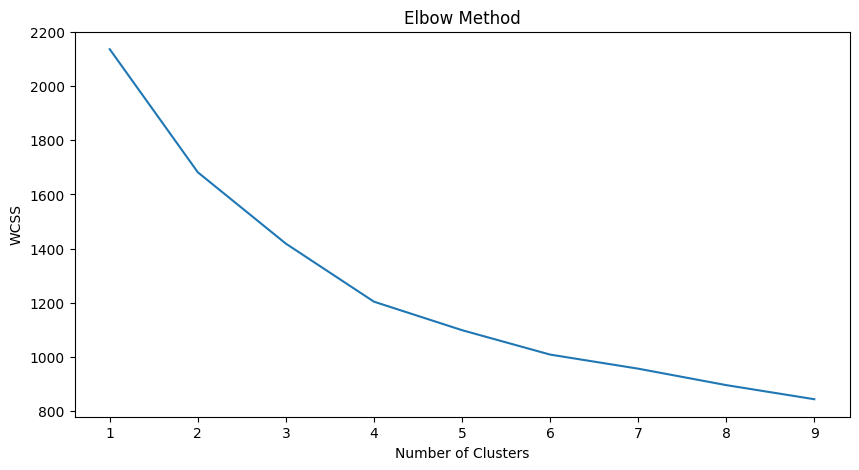

In [15]:
#Elbow Method
wcss = []
for i in range (1,10):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state=42)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)
    
plt.figure(figsize = (10,5))
plt.plot(range(1,10), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

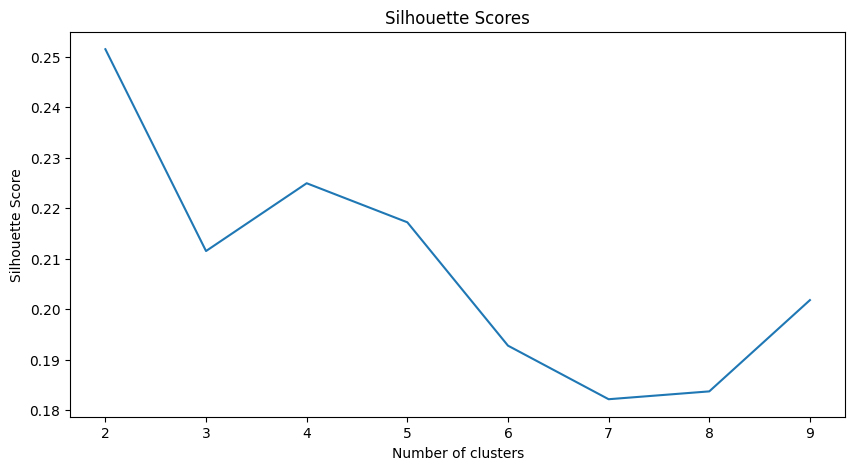

In [16]:
#Silhoutte Score
silhouette_scores = []
for i in range(2, 10):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(scaled_features)
    silhouette_scores.append(silhouette_score(scaled_features, kmeans.labels_))

plt.figure(figsize=(10, 5))
plt.plot(range(2,10), silhouette_scores)
plt.title('Silhouette Scores')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

In [23]:
print('SILHOUTTE SCORE:')
for i in range(len(silhouette_scores)):
    print(f'Cluster {i}: {silhouette_scores[i]}')

print('----------------------------------------')
print('ELBOW SCORE:')
for i in range(len(wcss)):
    print(f'Cluster {i}: {wcss[i]}')

SILHOUTTE SCORE:
Cluster 0: 0.2515207824614202
Cluster 1: 0.21154442462493298
Cluster 2: 0.22497414410114783
Cluster 3: 0.2172383290345235
Cluster 4: 0.19280367703332477
Cluster 5: 0.18219064492118067
Cluster 6: 0.18374384539076946
Cluster 7: 0.20182618543491823
----------------------------------------
ELBOW SCORE:
Cluster 0: 2136.0
Cluster 1: 1681.7125340520215
Cluster 2: 1418.357179740285
Cluster 3: 1204.1347201675492
Cluster 4: 1098.9778143074209
Cluster 5: 1008.8432547489888
Cluster 6: 956.8821986392031
Cluster 7: 896.1547830355255
Cluster 8: 844.0929708101066


## Clustering

In [25]:
optimal_clusters = 5

In [26]:
kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels = kmeans.fit_predict(scaled_features)

In [27]:
resumes['Cluster'] = cluster_labels
resumes.head()

,cleaned_text,Degree,total_exp,total_work,B-HSkill,B-SSkill,B-Tech,deg,Cluster
0,information technology summary dedicated infor...,Master,25.33,3.0,20,1,6,2,0
2,information technology supervisor summary seek...,Undergraduate,9.67,4.0,19,6,7,3,4
3,information technology instructor summary seve...,Doctor,22.42,4.0,29,2,15,1,2
4,information technology manager/analyst profess...,Bachelor,24.92,3.0,11,0,0,0,2
5,christopher townes summary knowledgeable infor...,Undergraduate,7.42,3.0,32,0,4,3,0


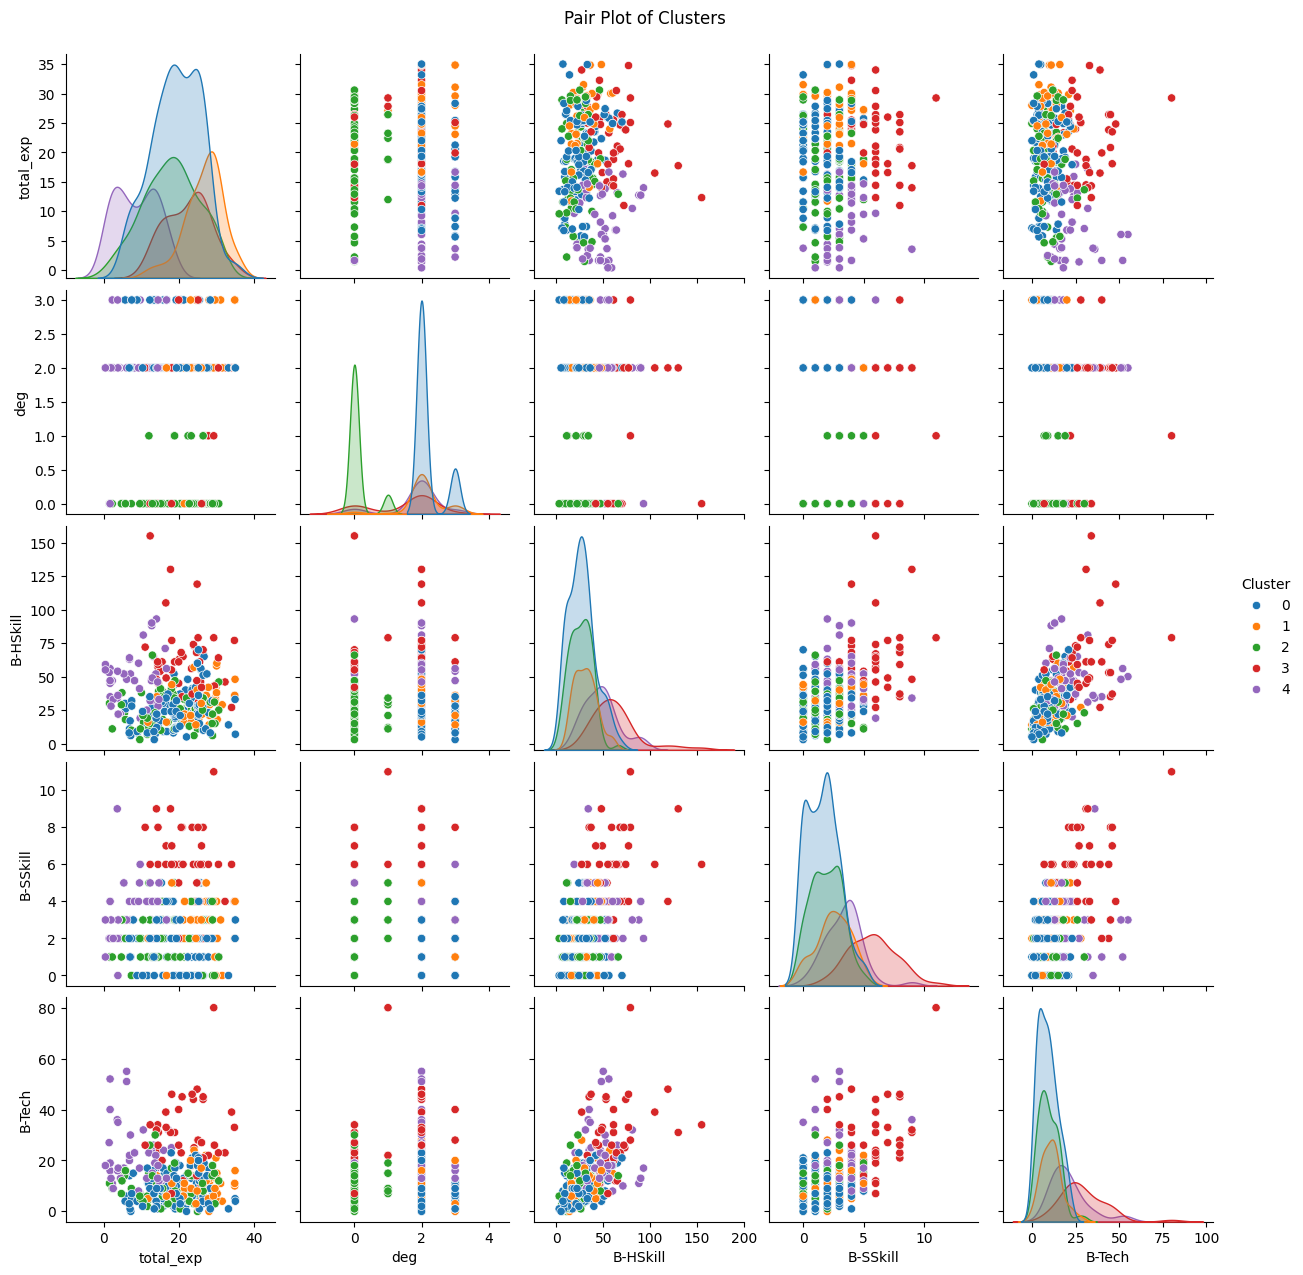

In [28]:
sns.pairplot(
    resumes,
    hue = 'Cluster',
    vars = ['total_exp', 'deg', 'B-HSkill', 'B-SSkill', 'B-Tech'],
    palette=sns.color_palette("tab10")
)
plt.suptitle('Pair Plot of Clusters', y=1.02)
plt.show()

## Clustering with PCA and KMedoids

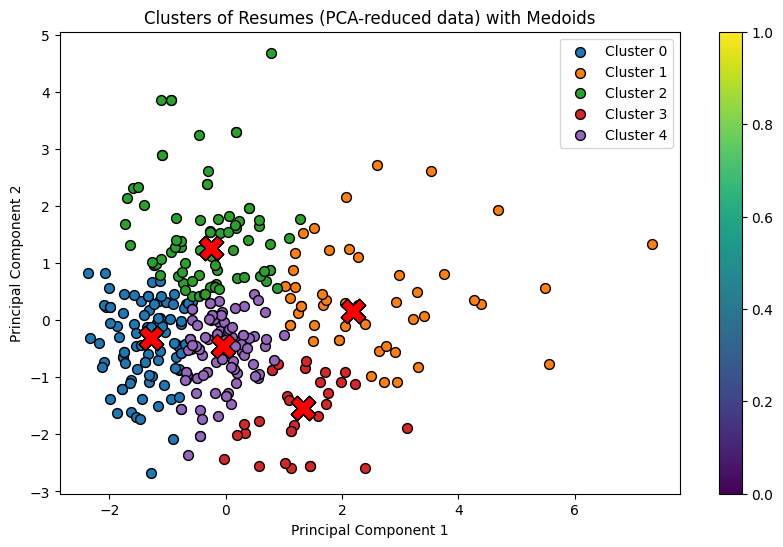

In [31]:
from sklearn_extra.cluster import KMedoids

pca = PCA(n_components=2)  # Reducing to 2 dimensions for visualization purposes
pca_features = pca.fit_transform(scaled_features)

pca_features_df = pd.DataFrame(pca_features, columns=['PC1', 'PC2'])

kmedoids = KMedoids(n_clusters=optimal_clusters, init='k-medoids++', max_iter=300, random_state=42)
cluster_labels = kmedoids.fit_predict(pca_features_df)

pca_features_df['Cluster'] = cluster_labels

medoids = kmedoids.cluster_centers_

plt.figure(figsize=(10, 6))

for cluster_num in sorted(pca_features_df['Cluster'].unique()):
    cluster_data = pca_features_df[pca_features_df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['PC1'], cluster_data['PC2'], label=f'Cluster {int(cluster_num)}', cmap='viridis', marker='o', edgecolor='k', s=50)
    plt.scatter(medoids[:, 0], medoids[:, 1], s=300, c='red', marker='X', edgecolor='k')  # Medoids

plt.title('Clusters of Resumes (PCA-reduced data) with Medoids')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.legend() 
plt.show()

## Clustering with T-SNE with Centroids and Medoids

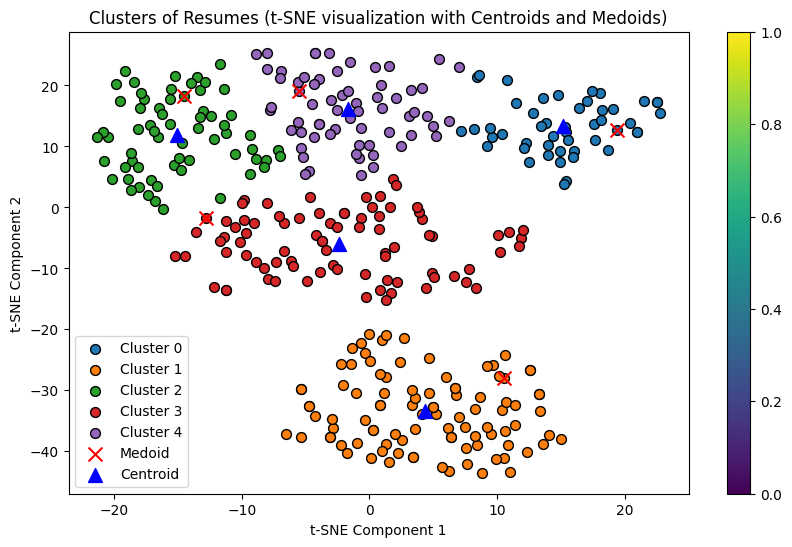

In [32]:
tsne = TSNE(n_components=2, random_state=42)
tsne_features = tsne.fit_transform(scaled_features)

tsne_features_df = pd.DataFrame(tsne_features, columns=['TSNE1', 'TSNE2'])

kmeans_tsne = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=42)
cluster_labels_tsne = kmeans_tsne.fit_predict(tsne_features_df)

tsne_features_df['Cluster'] = cluster_labels_tsne

def compute_medoids(data, cluster_labels):
    medoids = []
    for cluster_num in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster_num].drop(columns=['Cluster'])
        medoid_idx = pairwise_distances_argmin_min(cluster_data, cluster_data.mean(axis=0).values.reshape(1, -1))[0][0]
        medoids.append(cluster_data.iloc[medoid_idx])
    return pd.DataFrame(medoids)

def compute_centroids(data, cluster_labels):
    centroids = []
    for cluster_num in sorted(data['Cluster'].unique()):
        cluster_data = data[data['Cluster'] == cluster_num].drop(columns=['Cluster'])
        centroid = cluster_data.mean(axis=0)
        centroids.append(centroid)
    return pd.DataFrame(centroids, columns=data.columns.drop('Cluster'))

medoids_df = compute_medoids(tsne_features_df[['TSNE1', 'TSNE2', 'Cluster']], tsne_features_df['Cluster'])
centroids_df = compute_centroids(tsne_features_df[['TSNE1', 'TSNE2', 'Cluster']], tsne_features_df['Cluster'])

plt.figure(figsize=(10, 6))

for cluster_num in sorted(tsne_features_df['Cluster'].unique()):
    cluster_data = tsne_features_df[tsne_features_df['Cluster'] == cluster_num]
    plt.scatter(cluster_data['TSNE1'], cluster_data['TSNE2'], label=f'Cluster {int(cluster_num)}', cmap='viridis', marker='o', edgecolor='k', s=50)

plt.scatter(medoids_df['TSNE1'], medoids_df['TSNE2'], marker='x', color='red', s=100, label='Medoid')
plt.scatter(centroids_df['TSNE1'], centroids_df['TSNE2'], marker='^', color='blue', s=100, label='Centroid')

plt.title('Clusters of Resumes (t-SNE visualization with Centroids and Medoids)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar()
plt.legend()
plt.show()

In [33]:
#Check Cluster dengan nilai mean per cluster
cluster_means = pd.DataFrame()

for cluster_id in range(optimal_clusters):
    cluster_data = resumes[resumes['Cluster'] == cluster_id].describe().loc['mean']
    cluster_means[f'Cluster_{cluster_id}'] = cluster_data

cluster_means = cluster_means.transpose()

print(cluster_means)

           total_exp  total_work   B-HSkill  B-SSkill     B-Tech       deg  \
Cluster_0  19.280687    3.595420  27.061069  1.625954   8.923664  2.175573   
Cluster_1  26.574490    8.000000  30.877551  2.510204  10.959184  2.061224   
Cluster_2  17.821772    4.063291  25.632911  1.924051   9.405063  0.113924   
Cluster_3  22.347609    4.565217  61.956522  5.739130  29.043478  1.434783   
Cluster_4   8.605098    3.078431  47.607843  3.333333  21.078431  1.862745   

           Cluster  
Cluster_0      0.0  
Cluster_1      1.0  
Cluster_2      2.0  
Cluster_3      3.0  
Cluster_4      4.0  
